# Load Necessary Dependencies

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable # install through "conda install orange3"
from orangecontrib.associate.fpgrowth import * # install through "pip3 install Orange3-Associate"

%matplotlib inline

# Construct and Load the Groceries Dataset

In [2]:
grocery_items = set()
with open("grocery_dataset.txt") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in enumerate(reader):
        grocery_items.update(line)
output_list = list()
with open("grocery_dataset.txt") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in enumerate(reader):
        row_val = {item:0 for item in grocery_items}
        row_val.update({item:1 for item in line})
        output_list.append(row_val)
grocery_df = pd.DataFrame(output_list)

In [3]:
grocery_df.head()

,cleaner,canned fruit,ice cream,liquor (appetizer),meat,spread cheese,cream cheese,soups,beverages,frankfurter,...,berries,semi-finished bread,specialty vegetables,softener,spices,pot plants,dish cleaner,turkey,chewing gum,sweet spreads
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
grocery_df.shape

(9835, 169)

# View top sold items

In [5]:
total_item_count = sum(grocery_df.sum())
print(total_item_count)
item_summary_df = grocery_df.sum().sort_values(ascending = False).reset_index().head(n=20)
item_summary_df.rename(columns={item_summary_df.columns[0]:'item_name',item_summary_df.columns[1]:'item_count'}, inplace=True)
item_summary_df.head()

43367


,item_name,item_count
0,whole milk,2513
1,other vegetables,1903
2,rolls/buns,1809
3,soda,1715
4,yogurt,1372


# Visualize top sold items

Text(0.5, 1.0, 'Item sales distribution')

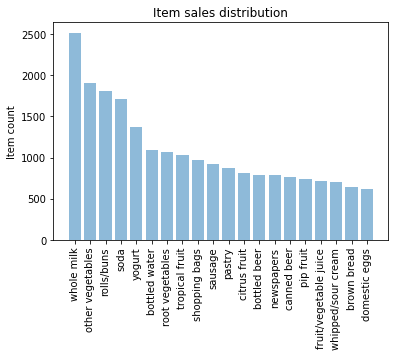

In [6]:
objects = (list(item_summary_df['item_name'].head(n=20)))
y_pos = np.arange(len(objects))
performance = list(item_summary_df['item_count'].head(n=20))
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Item sales distribution')

# Analyze items contributing to top sales

In [7]:
item_summary_df['item_perc'] = item_summary_df['item_count']/total_item_count
item_summary_df['total_perc'] = item_summary_df.item_perc.cumsum()
item_summary_df.head(10)

,item_name,item_count,item_perc,total_perc
0,whole milk,2513,0.057947,0.057947
1,other vegetables,1903,0.043881,0.101829
2,rolls/buns,1809,0.041714,0.143542
3,soda,1715,0.039546,0.183089
4,yogurt,1372,0.031637,0.214725
5,bottled water,1087,0.025065,0.239791
6,root vegetables,1072,0.024719,0.264510
7,tropical fruit,1032,0.023797,0.288307
8,shopping bags,969,0.022344,0.310651
9,sausage,924,0.021307,0.331957


# Analyze items contributing to top 50% of sales

In [8]:
item_summary_df[item_summary_df.total_perc <= 0.5].shape

(19, 4)

In [9]:
item_summary_df[item_summary_df.total_perc <= 0.5]

,item_name,item_count,item_perc,total_perc
0,whole milk,2513,0.057947,0.057947
1,other vegetables,1903,0.043881,0.101829
2,rolls/buns,1809,0.041714,0.143542
3,soda,1715,0.039546,0.183089
4,yogurt,1372,0.031637,0.214725
5,bottled water,1087,0.025065,0.239791
6,root vegetables,1072,0.024719,0.264510
7,tropical fruit,1032,0.023797,0.288307
8,shopping bags,969,0.022344,0.310651
9,sausage,924,0.021307,0.331957


This shows us that the top five items are responsible for 21.4% of the entire sales and only the top 20 items are responsible for over 50% of the sales!

# Construct Orange Table 

Before we go on using the package for finding association rules, we will discuss about the way data is represented in Orange library. The data representation is a little tricky but we will help you modify the existing data into the format required by Orange. Primarily we will focus on how to convert our pandas dataframes to the Orange Table data structure.

The Table data structure is the primary way to represent any tabular data in Orange. Although it is similar in some way to a numpy array or a pandas dataframe, it differs from them in the way it stores metadata about the actual data. In our case we can easily convert our pandas dataframe to the Table data structure by providing the metadata about our columns. We need to define the domain for each of our variables. The domain means the possible set of values that each of our variables can use. This information will be stored as metadata and will be used in later transformation of the data. As our columns are only having binary values—i.e. either 0 or 1—we can easily create the domain by using this information. The following code snippet helps us convert our dataframe to an Orange table.


In [10]:
input_assoc_rules = grocery_df
domain_grocery = Domain([DiscreteVariable.make(name=item,values=['0', '1']) for item in input_assoc_rules.columns])
data_gro_1 = Orange.data.Table.from_numpy(domain=domain_grocery,  X=input_assoc_rules.values,Y= None)

Here we defined the domain of our data by specifying each variable as a DiscreteVariable having values as (0, 1). Then using this domain, we created our Table structure for our data.

# Prune Dataset for frequently purchased items

Now we have all the pieces required to perform our rule-mining. But before proceeding, we want to take care
of one more important aspect of the analysis. We saw in the earlier section how only a handful of items are
responsible for bulk of our sales so we want to prune our dataset to reflect this information. For this we have
created a function **prune_dataset**, which will help us reduce the size of our dataset
based on our requirements. The function can be used for performing two types of pruning:

• Pruning based on percentage of total sales: The parameter total_sales_perc will
help us select the number of items that will explain the required percentage of sales.
The default value is 50% or 0.5.

• Pruning based on ranks of items: Another way to perform the pruning is to specify
the starting and the ending rank of the items for which we want to prune our dataset.

By default, we will only look for transactions which have at least two items, as transactions with only
one item are counter to the whole concept of association rule-mining. The following code snippet will help
us select only that subset of data which explain 40% of the total sales by leveraging our pruning function.

In [11]:
def prune_dataset(input_df, length_trans = 2, total_sales_perc = 0.5, start_item = None, end_item = None):
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
    item_count = input_df.sum().sort_values(ascending = False).reset_index()
    total_items = sum(input_df.sum().sort_values(ascending = False))
    item_count.rename(columns={item_count.columns[0]:'item_name',item_count.columns[1]:'item_count'}, inplace=True)
    if not start_item and not end_item: 
        item_count['item_perc'] = item_count['item_count'] / total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[item_count.total_perc < total_sales_perc]
    elif end_item > start_item:
        selected_items = list(item_count[start_item:end_item].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items],item_count[start_item:end_item]

In [12]:
output_df, item_counts = prune_dataset(input_df=grocery_df, length_trans=2,total_sales_perc=0.4)
print(output_df.shape)
print(list(output_df.columns))

(4585, 13)
['whole milk', 'other vegetables', 'rolls/buns', 'soda', 'yogurt', 'bottled water', 'root vegetables', 'tropical fruit', 'shopping bags', 'sausage', 'pastry', 'citrus fruit', 'bottled beer']


So we find out that we have only 13 items responsible for 40% of sales and 4585 transactions that have those items along with other items and we can also see what those items are. The next step is to convert this selected data into the required Table data structure.

# Association Rule Mining with FP Growth

In [13]:
input_assoc_rules = output_df
domain_grocery = Domain([DiscreteVariable.make(name=item,values=['0', '1']) for item in input_assoc_rules.columns])
data_gro_1 = Orange.data.Table.from_numpy(domain=domain_grocery,  X=input_assoc_rules.values,Y= None)
# entire domain is represented as binary variables
data_gro_1_en, mapping = OneHot.encode(data_gro_1, include_class=False)

The final step is creating our rules. We will specify a minsupport of 0.01—45 transactions at least—and see the number of frequent itemsets that we get before we specify confidence and generate our rules.

In [14]:
min_support = 0.01
print("num of required transactions = ", int(input_assoc_rules.shape[0]*min_support))
num_trans = input_assoc_rules.shape[0]*min_support
itemsets = dict(frequent_itemsets(data_gro_1_en, min_support=min_support))

num of required transactions =  45


In [15]:
len(itemsets)

166886

So we get a whopping 166,886 itemsets for a support of only 1%! This will increase exponentially if
we decrease the support or if we increase the number of items in our dataset. The next step is specifying a
confidence value and generating our rules. We have written a code snippet that will take a confidence value
and generate the rules that fulfill our specified support and confidence criteria. The rules generated are then
decoded using the mapping and variable names. Orange3-Associate also provides a helper function that will
help us extract metrics about each of these rules. The following code snippet will perform rule generation and
decoding of rules, and then compile it all in a neat dataframe that we can use for further analysis.

In [16]:
confidence = 0.3
rules_df = pd.DataFrame()

if len(itemsets) < 1000000: 
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(itemsets, confidence)
       if len(Q) == 1 ]

    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_gro_1, mapping)}
    
    eligible_ante = [v for k,v in names.items() if v.endswith("1")]
    
    N = input_assoc_rules.shape[0]
    
    rule_stats = list(rules_stats(rules, itemsets, N))
    
    rule_list_df = []
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]            
        cons = ex_rule_frm_rule_stat[1]
        named_cons = names[next(iter(cons))]
        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'coverage' : ex_rule_frm_rule_stat[4],
                             'strength' : ex_rule_frm_rule_stat[5],
                             'lift' : ex_rule_frm_rule_stat[6],
                             'leverage' : ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)
    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if not rules_df.empty:
        pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
    else:
        print("Unable to generate any rule")

Raw rules data frame of 16628 rules generated


# Sorting rules in our Grocery Dataset

The output of this code snippet consists of the association rules dataframe that we can use for our
analysis. You can play around with the item number, consequent, antecedent, support, and confidence
values to generate different rules. Let’s take some sample rules generated using transactions that explain
40% of total sales, min-support of 1% (required number of transactions >=45) and confidence greater than
30%. Here, we have collected rules having maximum lift for each of the items that can be a consequent (that
appear on the right side) by using the following code.

In [17]:
(pruned_rules_df[['antecedent','consequent',
                  'support','confidence','lift']].groupby('consequent')
                                                 .max()
                                                 .reset_index()
                                                 .sort_values(['lift', 'support','confidence'],
                                                              ascending=False))

,consequent,antecedent,support,confidence,lift
4,root vegetables,"yogurt, tropical fruit",228,0.463636,2.230611
5,sausage,"shopping bags, rolls/buns",59,0.393162,2.201037
8,tropical fruit,"yogurt, root vegetables",92,0.429907,2.156588
1,citrus fruit,"whole milk, other vegetables, tropical fruit",66,0.333333,2.125637
10,yogurt,"whole milk, tropical fruit",199,0.484211,1.891061
2,other vegetables,"yogurt, whole milk, tropical fruit",228,0.643836,1.826724
6,shopping bags,"soda, sausage",50,0.304878,1.782992
0,bottled water,"yogurt, soda",59,0.333333,1.707635
9,whole milk,"yogurt, tropical fruit",228,0.754098,1.703222
3,rolls/buns,"yogurt, tropical fruit",97,0.522222,1.679095


# Association rule mining on our Online Retail dataset

## Load and Filter Dataset

In [18]:
cs_mba = pd.read_excel(io=r'Online Retail.xlsx')
cs_mba_uk = cs_mba[cs_mba.Country == 'United Kingdom']

In [19]:
cs_mba_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Remove returned item as we are only interested in the buying patterns

In [20]:
cs_mba_uk = cs_mba_uk[~(cs_mba_uk.InvoiceNo.str.contains("C") == True)]
cs_mba_uk = cs_mba_uk[~cs_mba_uk.Quantity<0]

In [21]:
cs_mba_uk.shape

(486286, 8)

In [22]:
cs_mba_uk.InvoiceNo.value_counts().shape

(18786,)

## Build Transaction Dataset

In [23]:
items = list(cs_mba_uk.Description.unique())
grouped = cs_mba_uk.groupby('InvoiceNo')
transaction_level_df_uk = grouped.aggregate(lambda x: tuple(x)).reset_index()[['InvoiceNo','Description']]

In [24]:
transaction_dict = {item:0 for item in items}
output_dict = dict()
temp = dict()
for rec in transaction_level_df_uk.to_dict('records'):
    invoice_num = rec['InvoiceNo']
    items_list = rec['Description']
    transaction_dict = {item:0 for item in items}
    transaction_dict.update({item:1 for item in items if item in items_list})
    temp.update({invoice_num:transaction_dict})

new = [v for k,v in temp.items()]
tranasction_df = pd.DataFrame(new)
del(tranasction_df[tranasction_df.columns[0]])

In [25]:
tranasction_df.shape

(18786, 4058)

In [26]:
tranasction_df.head()

,WHITE METAL LANTERN,CREAM CUPID HEARTS COAT HANGER,KNITTED UNION FLAG HOT WATER BOTTLE,RED WOOLLY HOTTIE WHITE HEART.,SET 7 BABUSHKA NESTING BOXES,GLASS STAR FROSTED T-LIGHT HOLDER,HAND WARMER UNION JACK,HAND WARMER RED POLKA DOT,ASSORTED COLOUR BIRD ORNAMENT,POPPY'S PLAYHOUSE BEDROOM,...,SET OF 6 RIBBONS COUNTRY STYLE,SNACK TRAY RED VINTAGE DOILY,SET OF 6 RIBBONS PERFECTLY PRETTY,SET OF 6 RIBBONS PARTY,SET 10 CARDS SNOWY ROBIN 17099,SET 10 CARDS SWIRLY XMAS TREE 17104,"LETTER ""U"" BLING KEY RING",CREAM HANGING HEART T-LIGHT HOLDER,BLACK SIL'T SQU CANDLE PLATE,"PAPER CRAFT , LITTLE BIRDIE"
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
output_df_uk_n, item_counts_n = prune_dataset(input_df=tranasction_df, length_trans=2, start_item=0, end_item=15)
print(output_df_uk_n.shape)

(4644, 15)


In [28]:
output_df_uk_n.head()

,JUMBO BAG RED RETROSPOT,REGENCY CAKESTAND 3 TIER,PARTY BUNTING,LUNCH BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,SET OF 3 CAKE TINS PANTRY DESIGN,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG BLACK SKULL.,HEART OF WICKER SMALL,JUMBO BAG PINK POLKADOT,JUMBO SHOPPER VINTAGE RED PAISLEY,JUMBO STORAGE BAG SUKI,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,WOODEN PICTURE FRAME WHITE FINISH
12,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0
14,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
16,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
25,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
33,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0


## Association Rule Mining with FP Growth

In [29]:
input_assoc_rules = output_df_uk_n
domain_transac = Domain([DiscreteVariable.make(name=item,values=['0', '1']) for item in input_assoc_rules.columns])
data_tran_uk = Orange.data.Table.from_numpy(domain=domain_transac,  X=input_assoc_rules.values,Y= None)
data_tran_uk_en, mapping = OneHot.encode(data_tran_uk, include_class=True)

In [30]:
support = 0.05
print("num of required transactions = ", int(input_assoc_rules.shape[0]*support))
num_trans = input_assoc_rules.shape[0]*support
itemsets = dict(frequent_itemsets(data_tran_uk_en, support))

num of required transactions =  232


In [31]:
len(itemsets)

140723

In [32]:
confidence = 0.3
rules_df = pd.DataFrame()
if len(itemsets) < 1000000: 
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(itemsets, confidence)
       if len(Q) == 1 ]

    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_tran_uk, mapping)}
    
    eligible_ante = [v for k,v in names.items() if v.endswith("1")]
    
    N = input_assoc_rules.shape[0]
    
    rule_stats = list(rules_stats(rules, itemsets, N))
    
    rule_list_df = []
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]            
        cons = ex_rule_frm_rule_stat[1]
        named_cons = names[next(iter(cons))]
        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'coverage' : ex_rule_frm_rule_stat[4],
                             'strength' : ex_rule_frm_rule_stat[5],
                             'lift' : ex_rule_frm_rule_stat[6],
                             'leverage' : ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)
    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if not rules_df.empty:
        pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
    else:
        print("Unable to generate any rule")

Raw rules data frame of 1910 rules generated


## Sort and display rules

In [33]:
pd.options.display.max_colwidth = 100
(pruned_rules_df[['antecedent','consequent',
                  'support','confidence','lift']].groupby('consequent')
                                                 .max()
                                                 .reset_index()
                                                 .sort_values(['lift', 'support','confidence'],
                                                              ascending=False)).head(5)

,consequent,antecedent,support,confidence,lift
3,JUMBO STORAGE BAG SUKI,"JUMBO BAG RED RETROSPOT, JUMBO SHOPPER VINTAGE RED PAISLEY",405,0.750000,3.329828
0,JUMBO BAG PINK POLKADOT,"JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO STORAGE BAG SUKI",405,0.721362,3.172354
2,JUMBO SHOPPER VINTAGE RED PAISLEY,"JUMBO BAG RED RETROSPOT, JUMBO STORAGE BAG SUKI",384,0.687316,3.129308
1,JUMBO BAG RED RETROSPOT,"JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO STORAGE BAG SUKI",405,0.876404,2.435681
4,LUNCH BAG RED RETROSPOT,"JUMBO BAG RED RETROSPOT, JUMBO BAG PINK POLKADOT",236,0.300637,1.138791
